In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/completo-definitivo/TABLE.xlsx - TABLE.csv
/kaggle/input/todos-interfaces/TABLE.xlsx - TABLE.csv


In [2]:
def comma_to_dot(df,j):
    
    l = df.iloc[:,j].tolist()
    
    new = []
    
    for i in range(len(l)):
            
        new.append(float(str(l[i]).replace(',', '.')))
            
    df.iloc[:,j] = new

In [3]:
df = pd.read_csv('../input/completo-definitivo/TABLE.xlsx - TABLE.csv')

for j in range(1,len(df.columns.tolist())):

    comma_to_dot(df,j)  #substituído ponto por vírgula
    
df = df.dropna(axis=1, how='all')
df = df.fillna(0)

In [4]:
df.head()

,OIL,IFT,CONCENTRATION,AD.WHB.ANTHRACENE.DAT,AD.WHB.BENZENE.DAT,AD.WHB.BENZOPYRENE.DAT,AD.WHB.M-XYLENE.DAT,AD.WHB.NAPHTHALENE.DAT,AD.WHB.O-XYLENE.DAT,AD.WHB.PHENANTHERENE.DAT,...,WAT.ORD.VECT1.Z.dat,WAT.ORD.VECT2.X.dat,WAT.ORD.VECT2.Y.dat,WAT.ORD.VECT2.Z.dat,WHB.DAT,WO.HC.DAT,WO.OH.DAT,WO.TOT.DAT,WW.HB.DAT,WWHB.DAT
0,heptane-brine,52.365135,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.022229,0.036508,0.034620,-0.071128,0.0,4.493488,6.113280,6.197603,2.279085,2.279085
1,heptane-brine,51.956841,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.005300,0.032287,0.029246,-0.061533,0.0,4.449064,6.093612,6.184882,2.266388,2.266388
2,heptane-brine,52.675557,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.006419,0.026112,0.033939,-0.060050,0.0,4.466210,6.110209,6.205236,2.248017,2.248017
3,heptane-brine,51.308806,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.007872,0.026928,0.032474,-0.059402,0.0,4.486348,6.113370,6.198278,2.268074,2.268074
4,heptane-brine,52.359999,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.007227,0.031506,0.033387,-0.064894,0.0,4.472240,6.087938,6.177224,2.240587,2.240587


# XGBoost

In [5]:
import sklearn
from pylab import rcParams
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df.drop([' OIL','IFT'], axis=1)
y = pd.DataFrame(df['IFT'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

ss_x = StandardScaler()
ss_y = StandardScaler()

X_train_scaled = ss_x.fit_transform(X_train)
X_test_scaled = ss_x.transform(X_test)
y_train_scaled = ss_y.fit_transform(y_train)
y_test_scaled = ss_y.transform(y_test)

In [7]:
def train_model(params):
    
    n_estimators = params[0]    
    learning_rate = params[1]
    max_depth = params[2]
    
    print(params, '\n')
    
    model = XGBRegressor(n_estimators = n_estimators,
                             learning_rate = learning_rate,
                             max_depth = max_depth,
                             random_state=0)
    
    model.fit(X_train_scaled, y_train_scaled)
    
    predicted_scaled = model.predict(X_test_scaled)

    y_test = ss_y.inverse_transform(y_test_scaled.reshape(-1, 1)).reshape(-1,)
    predicted = ss_y.inverse_transform(predicted_scaled.reshape(-1, 1)).reshape(-1,)
    
    errors = sklearn.metrics.mean_absolute_error(y_test, predicted)
    
    return errors
    
    
space = [(100, 1000), # n_estimators
         (0.0001, 0.5, 'log-uniform'),  # learning_rate 
         (2, 7, 'log-uniform')]  # max_depth

from skopt import gp_minimize
#resultados_gp = gp_minimize(train_model, space, random_state=1, verbose=1, n_calls=50, n_random_starts=25)

In [8]:
#[1000, 0.10745087245052558, 2] 

model = XGBRegressor(n_estimators = 1000,
                             learning_rate = 0.10745,
                             max_depth = 2,
                             random_state=0)
model.fit(X_train_scaled, y_train_scaled)


importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

importances = importances[importances['Importance'] >= 0.01]

In [9]:
# example of calculate the mean absolute error
from sklearn.metrics import mean_absolute_error

# make predictions for test data
predicted_scaled = model.predict(X_test_scaled)

y_test = ss_y.inverse_transform(y_test_scaled.reshape(-1, 1)).reshape(-1,)
predicted = ss_y.inverse_transform(predicted_scaled.reshape(-1, 1)).reshape(-1,)

# calculate errors
errors = mean_absolute_error(y_test, predicted)
# report error
print(errors)

#erro de uma unidade

0.3842809283128007


In [10]:
r2 = sklearn.metrics.r2_score(y_test, predicted)
print('r2 score for perfect model is', r2)

r2 score for perfect model is 0.9808154944732036


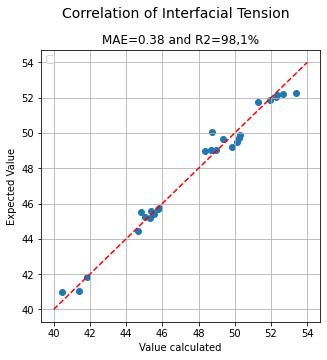

In [11]:
rcParams['figure.figsize'] = 5, 5


fig, ax = plt.subplots()
x = range(40,55)
y=x

ax.plot(x,y,"r--")
ax.scatter(y_test, predicted)

ax.set(xlabel='Value calculated', ylabel='Expected Value',
       title='MAE=0.38 and R2=98,1%')

plt.suptitle("Correlation of Interfacial Tension", y=1, fontsize=14)

ax.grid()
plt.legend()
plt.show()

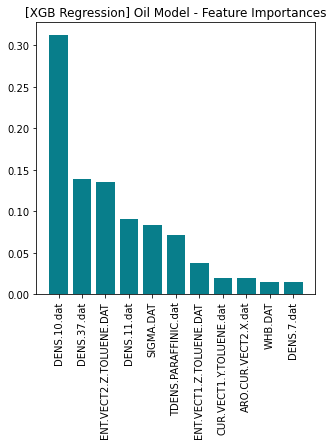

In [12]:
rcParams['figure.figsize'] = 5,5

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')


plt.title('[XGB Regression] Oil Model - Feature Importances', size=12)
plt.xticks(rotation='vertical')
plt.show()

In [13]:
importances

,Attribute,Importance
255,DENS.10.dat,0.312081
268,DENS.37.dat,0.138638
438,ENT.VECT2.Z.TOLUENE.DAT,0.134900
256,DENS.11.dat,0.090996
799,SIGMA.DAT,0.083069
802,TDENS.PARAFFINIC.dat,0.071121
384,ENT.VECT1.Z.TOLUENE.DAT,0.037654
118,CUR.VECT1.Y.TOLUENE.dat,0.019095
17,ARO.CUR.VECT2.X.dat,0.018978
836,WHB.DAT,0.014384


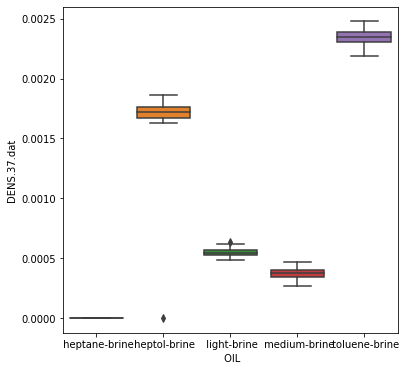

In [14]:
rcParams['figure.figsize'] = 6, 6

ax = sns.boxplot(x = " OIL", y = 'DENS.37.dat', data = df)

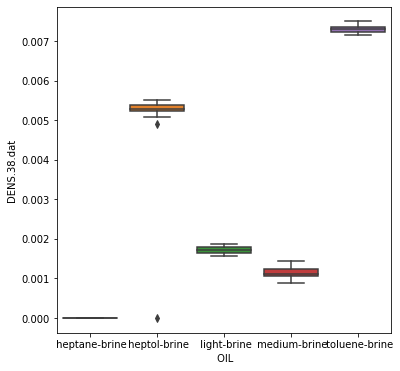

In [15]:
rcParams['figure.figsize'] = 6, 6

ax = sns.boxplot(x = " OIL", y = 'DENS.38.dat', data = df)

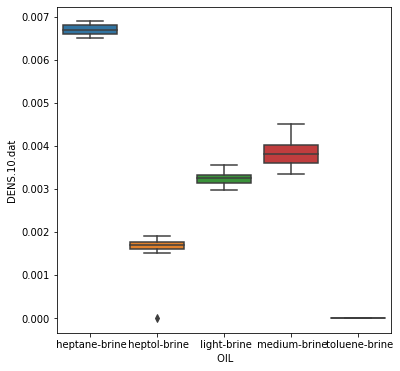

In [16]:
rcParams['figure.figsize'] = 6, 6
ax = sns.boxplot(x = " OIL", y = 'DENS.10.dat', data = df)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, ' heptane-brine'),
  Text(1, 0, ' heptol-brine'),
  Text(2, 0, ' light-brine'),
  Text(3, 0, ' medium-brine'),
  Text(4, 0, ' toluene-brine')])

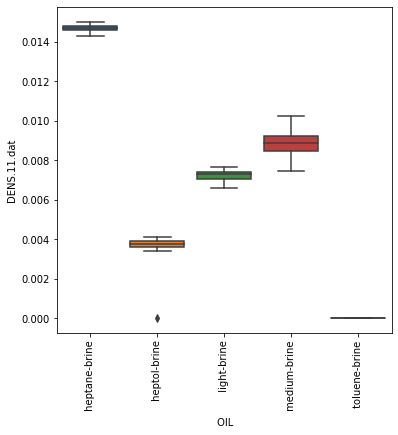

In [17]:
rcParams['figure.figsize'] = 6, 6
ax = sns.boxplot(x = " OIL", y = 'DENS.11.dat', data = df)
plt.xticks(rotation='vertical')

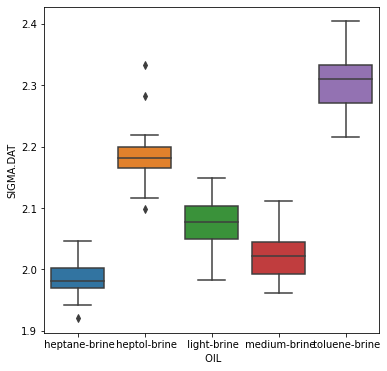

In [18]:
rcParams['figure.figsize'] = 6, 6
ax = sns.boxplot(x = " OIL", y = 'SIGMA.DAT', data = df)

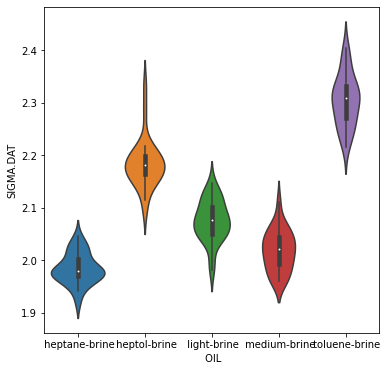

In [19]:
rcParams['figure.figsize'] = 6, 6
ax = sns.violinplot(x = " OIL", y = 'SIGMA.DAT', data = df)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, ' heptane-brine'),
  Text(1, 0, ' heptol-brine'),
  Text(2, 0, ' light-brine'),
  Text(3, 0, ' medium-brine'),
  Text(4, 0, ' toluene-brine')])

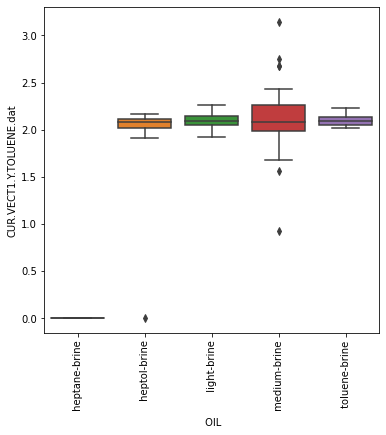

In [20]:
rcParams['figure.figsize'] = 6, 6

ax = sns.boxplot(x = " OIL", y = 'CUR.VECT1.Y.TOLUENE.dat', data = df)
plt.xticks(rotation='vertical')

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, ' heptane-brine'),
  Text(1, 0, ' heptol-brine'),
  Text(2, 0, ' light-brine'),
  Text(3, 0, ' medium-brine'),
  Text(4, 0, ' toluene-brine')])

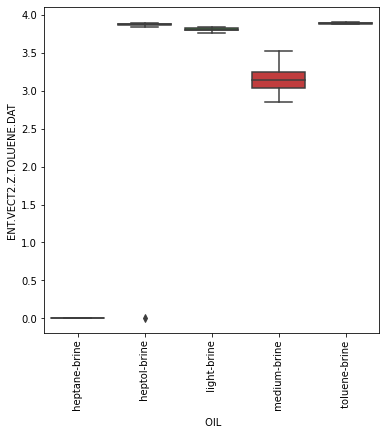

In [21]:
rcParams['figure.figsize'] = 6, 6
ax = sns.boxplot(x = " OIL", y = 'ENT.VECT2.Z.TOLUENE.DAT', data = df)
plt.xticks(rotation='vertical')

# XGBoost with cross validation

In [22]:
from sklearn.model_selection import KFold

In [23]:
X = df.drop([' OIL','IFT'], axis=1).values
y = pd.DataFrame(df['IFT']).values

In [24]:
def train_model(params):
    
    n_estimators = params[0]    
    learning_rate = params[1]
    max_depth = params[2]
    
    print(params, '\n')
    
    model = XGBRegressor(n_estimators = n_estimators,
                             learning_rate = learning_rate,
                             max_depth = max_depth,
                             random_state=0)
   
    mae_t = []
    r2_t = []
    kf = KFold(5, shuffle=True, random_state=0)

    for lines_train_kf, lines_test_kf in kf.split(X):
       
        x_train_kf, x_test_kf = X[lines_train_kf], X[lines_test_kf]
        y_train_kf, y_test_kf = y[lines_train_kf], y[lines_test_kf]

        scaler_x_train_kf = ss_x
       
        x_train_kf = scaler_x_train_kf.fit_transform(x_train_kf)
        x_test_kf = scaler_x_train_kf.transform(x_test_kf)

        scaler_y_train_kf = ss_y
        y_train_kf = scaler_y_train_kf.fit_transform(y_train_kf.reshape(-1, 1)).reshape(-1,)

###############################################################################
   
        model.fit(x_train_kf, y_train_kf)
       
        predictions = model.predict(x_test_kf).reshape(-1,)

        y_train_kf = scaler_y_train_kf.inverse_transform(y_train_kf.reshape(-1, 1)).reshape(-1,)
       
        predictions = scaler_y_train_kf.inverse_transform(predictions.reshape(-1, 1)).reshape(-1,)
       
        mae = mean_absolute_error(y_test_kf, predictions)
        mae_t.append(mae)

        r2 = sklearn.metrics.r2_score(y_test_kf, predictions)
        r2_t.append(r2)
       
    return np.mean(mae_t,axis=0)
    #return -r2_score(y_train_test, predictions)


space = [(100, 1000), # n_estimators
         (0.0001, 0.5, 'log-uniform'),  # learning_rate
         (2, 7, 'log-uniform')]  # max_depth

#from skopt import dummy_minimize
#resultado = dummy_minimize(train_model, space, random_state=1, verbose=1, n_calls=200)

from skopt import gp_minimize
#resultados_gp = gp_minimize(train_model, space, random_state=1, verbose=1, n_calls=50, n_random_starts=25)

In [25]:
#[1000, 0.061511475574722765, 2] 

model = XGBRegressor(n_estimators = 1000,
                             learning_rate = 0.061511475574722765,
                             max_depth = 2,
                             random_state=0)

model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.061511475574722765, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
# make predictions for test data
predicted_scaled = model.predict(X_test_scaled)

y_test = ss_y.inverse_transform(y_test_scaled.reshape(-1, 1)).reshape(-1,)
predicted = ss_y.inverse_transform(predicted_scaled.reshape(-1, 1)).reshape(-1,)

# calculate errors
errors = mean_absolute_error(y_test, predicted)
# report error
print(errors)

0.43004017006835965


In [27]:
r2 = sklearn.metrics.r2_score(y_test, predicted)
print('r2 score for perfect model is', r2)

r2 score for perfect model is 0.9782646204724694


# Regressão de Multiplas Variáveis

https://www.analyticsvidhya.com/blog/2021/05/multiple-linear-regression-using-python-and-scikit-learn/

In [28]:
importances["Attribute"].to_list()

['DENS.10.dat',
 'DENS.37.dat',
 'ENT.VECT2.Z.TOLUENE.DAT',
 'DENS.11.dat',
 'SIGMA.DAT',
 'TDENS.PARAFFINIC.dat',
 'ENT.VECT1.Z.TOLUENE.DAT',
 'CUR.VECT1.Y.TOLUENE.dat',
 'ARO.CUR.VECT2.X.dat',
 'WHB.DAT',
 'DENS.7.dat']

In [29]:
importances['Attribute'].iloc[:9]

255                DENS.10.dat
268                DENS.37.dat
438    ENT.VECT2.Z.TOLUENE.DAT
256                DENS.11.dat
799                  SIGMA.DAT
802       TDENS.PARAFFINIC.dat
384    ENT.VECT1.Z.TOLUENE.DAT
118    CUR.VECT1.Y.TOLUENE.dat
17         ARO.CUR.VECT2.X.dat
Name: Attribute, dtype: object

In [30]:
X = df[importances["Attribute"].iloc[:9].to_list()]
y = pd.DataFrame(df['IFT'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

ss_x = StandardScaler()
ss_y = StandardScaler()

X_train_scaled = ss_x.fit_transform(X_train)
X_test_scaled = ss_x.transform(X_test)
y_train_scaled = ss_y.fit_transform(y_train)
y_test_scaled = ss_y.transform(y_test)

In [31]:
X.describe()

,DENS.10.dat,DENS.37.dat,ENT.VECT2.Z.TOLUENE.DAT,DENS.11.dat,SIGMA.DAT,TDENS.PARAFFINIC.dat,ENT.VECT1.Z.TOLUENE.DAT,CUR.VECT1.Y.TOLUENE.dat,ARO.CUR.VECT2.X.dat
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,0.003085,0.000986,2.919143,0.006883,2.113804,0.107521,2.858964,1.660617,1.692923
std,0.002268,0.000895,1.526541,0.005003,0.124414,0.080442,1.491001,0.875820,0.874359
min,0.000000,0.000000,0.000000,0.000000,1.920810,0.000000,0.000000,0.000000,0.000000
25%,0.001600,0.000334,3.026598,0.003612,2.009062,0.059529,3.007850,1.890838,1.969007
50%,0.003263,0.000540,3.809179,0.007287,2.080090,0.113599,3.706128,2.071318,2.104576
75%,0.004028,0.001762,3.879445,0.009225,2.198875,0.126140,3.784943,2.125006,2.177802
max,0.006888,0.002477,3.913038,0.015022,2.403870,0.246957,3.846455,3.144975,2.434247


In [32]:
# importing module
from sklearn.linear_model import LinearRegression
# creating an object of LinearRegression class
LR = LinearRegression()
# fitting the training data
LR.fit(X_train_scaled, y_train_scaled)

LinearRegression()

In [33]:
# make predictions for test data
predicted_scaled = LR.predict(X_test_scaled)

y_test = ss_y.inverse_transform(y_test_scaled.reshape(-1, 1)).reshape(-1,)
predicted = ss_y.inverse_transform(predicted_scaled.reshape(-1, 1)).reshape(-1,)

# calculate errors
errors = mean_absolute_error(y_test, predicted)
# report error
print(errors)

0.5960034303166167


In [34]:
# importing r2_score module
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# predicting the accuracy score
score=r2_score(y_test, predicted)
print('r2 socre is ', score)
print('mean_sqrd_error is ' ,mean_squared_error(y_test, predicted))
print('root_mean_squared error of is ',np.sqrt(mean_squared_error(y_test, predicted)))

r2 socre is  0.955927367995904
mean_sqrd_error is  0.565939424702221
root_mean_squared error of is  0.7522894553974694


In [35]:
X.columns

Index(['DENS.10.dat', 'DENS.37.dat', 'ENT.VECT2.Z.TOLUENE.DAT', 'DENS.11.dat',
       'SIGMA.DAT', 'TDENS.PARAFFINIC.dat', 'ENT.VECT1.Z.TOLUENE.DAT',
       'CUR.VECT1.Y.TOLUENE.dat', 'ARO.CUR.VECT2.X.dat'],
      dtype='object')

In [36]:
LR.coef_

array([[ 0.62635694, -0.52698468,  0.71778813, -0.19813188, -0.28668924,
        -0.13309696, -0.41465289, -0.02497427, -0.14790518]])

In [37]:
LR.intercept_

array([3.29859097e-17])

# A eq. linear para previsão da tensão interfacial é 

**IFT** = 8.5e-17 + **0.37**[DENS.10.dat] - **0.53**[DENS.37.dat] + **0.86**[ENT.VECT2.Z.TOLUENE.DAT] - **0.32**[DENS.11.dat] - **0.28**[SIGMA.DAT] + **0.67**[TDENS.PARAFFINIC.dat] - **0.53**[ENT.VECT1.Z.TOLUENE.DAT] - **0.02**[CUR.VECT1.Y.TOLUENE.dat] - **0.17**[ARO.CUR.VECT2.X.dat] - **0.008**[WHB.DAT] - **0.42**[DENS.7.dat]

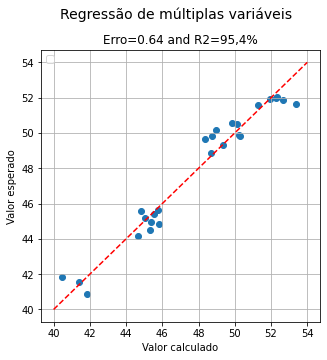

In [38]:
rcParams['figure.figsize'] = 5, 5


fig, ax = plt.subplots()
x = range(40,55)
y=x

ax.plot(x,y,"r--")
ax.scatter(y_test, predicted)

ax.set(xlabel='Valor calculado', ylabel='Valor esperado',
       title='Erro=0.64 and R2=95,4%')

plt.suptitle("Regressão de múltiplas variáveis", y=1, fontsize=14)

ax.grid()
plt.legend()
plt.show()

# Gráficos

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, ' heptane-brine'),
  Text(1, 0, ' heptol-brine'),
  Text(2, 0, ' light-brine'),
  Text(3, 0, ' medium-brine'),
  Text(4, 0, ' toluene-brine')])

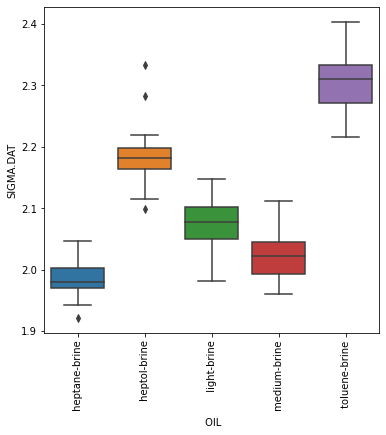

In [39]:
rcParams['figure.figsize'] = 6, 6
sns.boxplot(x=" OIL", y="SIGMA.DAT", data=df);
plt.xticks(rotation='vertical')

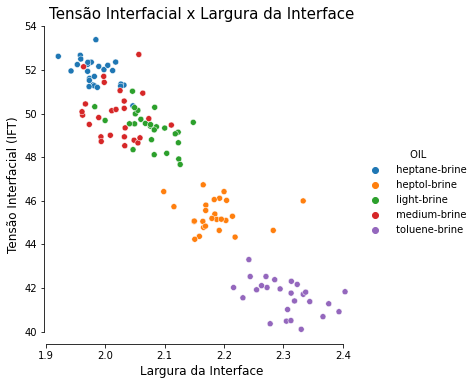

In [40]:
rcParams['figure.figsize'] = 10, 10
ax = sns.relplot(x="SIGMA.DAT", y="IFT", data=df, hue=' OIL');
sns.set_style("darkgrid")
plt.title("Tensão Interfacial x Largura da Interface", size=15)
plt.xlabel("Largura da Interface",fontsize=12)
plt.ylabel("Tensão Interfacial (IFT)",fontsize=12)

sns.despine(trim=True);

In [41]:
X = df['SIGMA.DAT'].values.reshape(-1, 1)
y = pd.DataFrame(df['IFT'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

ss_x = StandardScaler()
ss_y = StandardScaler()

X_train_scaled = ss_x.fit_transform(X_train)
X_test_scaled = ss_x.transform(X_test)
y_train_scaled = ss_y.fit_transform(y_train)
y_test_scaled = ss_y.transform(y_test)

In [42]:
# importing module
from sklearn.linear_model import LinearRegression
# creating an object of LinearRegression class
LR = LinearRegression()
# fitting the training data
LR.fit(X_train_scaled, y_train_scaled)

LinearRegression()

In [43]:
# make predictions for test data
predicted_scaled = LR.predict(X_test_scaled)

y_test = ss_y.inverse_transform(y_test_scaled.reshape(-1, 1)).reshape(-1,)
predicted = ss_y.inverse_transform(predicted_scaled.reshape(-1, 1)).reshape(-1,)

# calculate errors
errors = mean_absolute_error(y_test, predicted)
# report error
print(errors)

1.1040949950950651


In [44]:
# importing r2_score module
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# predicting the accuracy score
score=r2_score(y_test, predicted)
print('r2 socre is ', score)
print('mean_sqrd_error is ' ,mean_squared_error(y_test, predicted))
print('root_mean_squared error of is ',np.sqrt(mean_squared_error(y_test, predicted)))

r2 socre is  0.8622651447006372
mean_sqrd_error is  1.7686618934471778
root_mean_squared error of is  1.3299104832458377


In [45]:
LR.coef_

array([[-0.94291829]])

In [46]:
LR.intercept_

array([-1.88988206e-15])

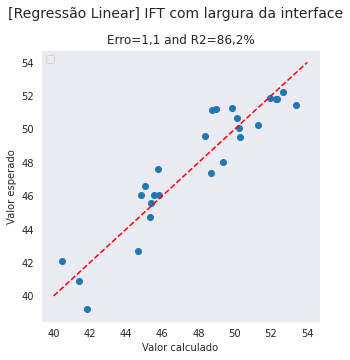

In [47]:
rcParams['figure.figsize'] = 5, 5


fig, ax = plt.subplots()
x = range(40,55)
y=x

ax.plot(x,y,"r--")
ax.scatter(y_test, predicted)

ax.set(xlabel='Valor calculado', ylabel='Valor esperado',
       title='Erro=1,1 and R2=86,2%')

plt.suptitle("[Regressão Linear] IFT com largura da interface", y=1, fontsize=14)

ax.grid()
plt.legend()
plt.show()

In [48]:
curt = df.loc[:,['CUR.' in i for i in df.columns]].columns.to_list()

ent = df.loc[:,['ENT.' in i for i in df.columns]].columns.to_list()

tort = df.loc[:,['TORT.' in i for i in df.columns]].columns.to_list()


In [49]:
curt.append(" OIL")
curt.append("IFT")

In [50]:
ent.append(" OIL")
ent.append("IFT")

# CURTOSE

In [51]:
df_c = df[curt]

df_c.head()

,ARO.CUR.PLANE.X.dat,ARO.CUR.PLANE.Y.dat,ARO.CUR.PLANE.Z.dat,ARO.CUR.VECT1.X.dat,ARO.CUR.VECT1.Y.dat,ARO.CUR.VECT1.Z.dat,ARO.CUR.VECT2.X.dat,ARO.CUR.VECT2.Y.dat,ARO.CUR.VECT2.Z.dat,CUR.PLANE.X.123-TRIMETHYLBENZENE.dat,...,WAT.CUR.PLANE.Y.dat,WAT.CUR.PLANE.Z.dat,WAT.CUR.VECT1.X.dat,WAT.CUR.VECT1.Y.dat,WAT.CUR.VECT1.Z.dat,WAT.CUR.VECT2.X.dat,WAT.CUR.VECT2.Y.dat,WAT.CUR.VECT2.Z.dat,OIL,IFT
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.561338,1.925766,2.132906,2.195467,2.283345,2.121978,2.168694,2.538558,heptane-brine,52.365135
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.573678,1.929213,2.194877,2.217862,2.227462,2.118364,2.153618,2.458727,heptane-brine,51.956841
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.598549,1.968286,2.271622,2.174078,2.215780,2.116517,2.153828,2.473796,heptane-brine,52.675557
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.542474,1.923359,2.256527,2.192664,2.234650,2.169711,2.120533,2.489917,heptane-brine,51.308806
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.566365,1.932589,2.203510,2.227833,2.249510,2.146334,2.128255,2.466109,heptane-brine,52.359999


In [52]:
df_c.columns.to_list()

['ARO.CUR.PLANE.X.dat',
 'ARO.CUR.PLANE.Y.dat',
 'ARO.CUR.PLANE.Z.dat',
 'ARO.CUR.VECT1.X.dat',
 'ARO.CUR.VECT1.Y.dat',
 'ARO.CUR.VECT1.Z.dat',
 'ARO.CUR.VECT2.X.dat',
 'ARO.CUR.VECT2.Y.dat',
 'ARO.CUR.VECT2.Z.dat',
 'CUR.PLANE.X.123-TRIMETHYLBENZENE.dat',
 'CUR.PLANE.X.124-TRIMETHYLBENZENE.dat',
 'CUR.PLANE.X.135-TRIMETHYLBENZENE.dat',
 'CUR.PLANE.X.ANTHRACENE.dat',
 'CUR.PLANE.X.BENZENE.dat',
 'CUR.PLANE.X.BENZOPYRENE.dat',
 'CUR.PLANE.X.CYCLOHEPTANE.dat',
 'CUR.PLANE.X.CYCLOHEXANE.dat',
 'CUR.PLANE.X.CYCLOOCTANE.dat',
 'CUR.PLANE.X.ISOBUTANE.dat',
 'CUR.PLANE.X.ISOPENTANE.dat',
 'CUR.PLANE.X.M-XYLENE.dat',
 'CUR.PLANE.X.NAPHTHALENE.dat',
 'CUR.PLANE.X.O-XYLENE.dat',
 'CUR.PLANE.X.PHENANTHERENE.dat',
 'CUR.PLANE.X.P-XYLENE.dat',
 'CUR.PLANE.X.PYRENE.dat',
 'CUR.PLANE.X.TOLUENE.dat',
 'CUR.PLANE.Y.123-TRIMETHYLBENZENE.dat',
 'CUR.PLANE.Y.124-TRIMETHYLBENZENE.dat',
 'CUR.PLANE.Y.135-TRIMETHYLBENZENE.dat',
 'CUR.PLANE.Y.ANTHRACENE.dat',
 'CUR.PLANE.Y.BENZENE.dat',
 'CUR.PLANE.Y.BENZOPYR

In [53]:
df_c.describe()

,ARO.CUR.PLANE.X.dat,ARO.CUR.PLANE.Y.dat,ARO.CUR.PLANE.Z.dat,ARO.CUR.VECT1.X.dat,ARO.CUR.VECT1.Y.dat,ARO.CUR.VECT1.Z.dat,ARO.CUR.VECT2.X.dat,ARO.CUR.VECT2.Y.dat,ARO.CUR.VECT2.Z.dat,CUR.PLANE.X.123-TRIMETHYLBENZENE.dat,...,WAT.CUR.PLANE.X.dat,WAT.CUR.PLANE.Y.dat,WAT.CUR.PLANE.Z.dat,WAT.CUR.VECT1.X.dat,WAT.CUR.VECT1.Y.dat,WAT.CUR.VECT1.Z.dat,WAT.CUR.VECT2.X.dat,WAT.CUR.VECT2.Y.dat,WAT.CUR.VECT2.Z.dat,IFT
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,...,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,2.239949,2.195964,1.669847,1.626253,1.624933,2.481189,1.692923,1.686296,2.024561,0.261359,...,2.516044,2.516040,1.935093,2.210578,2.205932,2.215262,2.126224,2.127672,2.432915,47.638738
std,1.222259,1.187592,0.872746,0.839162,0.839435,1.406822,0.874359,0.870706,1.065715,0.861935,...,0.228675,0.227500,0.172254,0.197066,0.198404,0.197972,0.189770,0.189589,0.222400,3.790439
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.107735
25%,2.431563,2.385455,1.951855,1.898822,1.887793,2.536770,1.969007,1.966795,2.316801,0.000000,...,2.500420,2.495265,1.935009,2.211072,2.211961,2.215578,2.124303,2.126202,2.414540,44.894079
50%,2.565879,2.550232,2.011075,2.030983,2.037089,2.772299,2.104576,2.108311,2.415272,0.000000,...,2.538290,2.542402,1.947879,2.226690,2.225074,2.229861,2.143162,2.141995,2.457096,48.935254
75%,2.726986,2.695686,2.108444,2.101578,2.095512,2.979242,2.177802,2.163734,2.579959,0.000000,...,2.572306,2.568593,1.963976,2.244434,2.239987,2.250764,2.157129,2.159160,2.480854,50.542605
max,4.289852,3.950058,2.745906,2.230399,2.236532,5.068983,2.434247,2.384955,3.499281,6.484937,...,2.672521,2.632256,2.004668,2.283945,2.288365,2.298449,2.214863,2.238185,2.772188,53.391183


In [54]:
px = df_c.loc[:,['.PLANE.X.' in i for i in df_c.columns]].columns.to_list()
py = df_c.loc[:,['.PLANE.Y.' in i for i in df_c.columns]].columns.to_list()
pz = df_c.loc[:,['.PLANE.Z.' in i for i in df_c.columns]].columns.to_list()

v1 = df_c.loc[:,['.VECT1.' in i for i in df_c.columns]].columns.to_list()
v2 = df_c.loc[:,['.VECT2.' in i for i in df_c.columns]].columns.to_list()

x = df_c.loc[:,['.X.' in i for i in df_c.columns]].columns.to_list()
y = df_c.loc[:,['.Y.' in i for i in df_c.columns]].columns.to_list()
z = df_c.loc[:,['.Z.' in i for i in df_c.columns]].columns.to_list()

In [55]:
px.append(' OIL')
px.append('IFT')
py.append(' OIL')
py.append('IFT')
pz.append(' OIL')
pz.append('IFT')

v1.append(' OIL')
v1.append('IFT')
v2.append(' OIL')
v2.append('IFT')

x.append(' OIL')
x.append('IFT')
y.append(' OIL')
y.append('IFT')
z.append(' OIL')
z.append('IFT')

In [56]:
df_px = df_c[px]
df_py = df_c[py]
df_pz = df_c[pz]

df_v1 = df_c[v1]
df_v2 = df_c[v2]

df_x = df_c[x]
df_y = df_c[y]
df_z = df_c[z]

df_px.head()

,ARO.CUR.PLANE.X.dat,CUR.PLANE.X.123-TRIMETHYLBENZENE.dat,CUR.PLANE.X.124-TRIMETHYLBENZENE.dat,CUR.PLANE.X.135-TRIMETHYLBENZENE.dat,CUR.PLANE.X.ANTHRACENE.dat,CUR.PLANE.X.BENZENE.dat,CUR.PLANE.X.BENZOPYRENE.dat,CUR.PLANE.X.CYCLOHEPTANE.dat,CUR.PLANE.X.CYCLOHEXANE.dat,CUR.PLANE.X.CYCLOOCTANE.dat,...,CUR.PLANE.X.O-XYLENE.dat,CUR.PLANE.X.PHENANTHERENE.dat,CUR.PLANE.X.P-XYLENE.dat,CUR.PLANE.X.PYRENE.dat,CUR.PLANE.X.TOLUENE.dat,ISO.CUR.PLANE.X.dat,NAP.CUR.PLANE.X.dat,WAT.CUR.PLANE.X.dat,OIL,IFT
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.672521,heptane-brine,52.365135
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.577311,heptane-brine,51.956841
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.515398,heptane-brine,52.675557
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.562462,heptane-brine,51.308806
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.581421,heptane-brine,52.359999


In [57]:
for i in range(26):
    df = df.drop(i, axis=0)
    

Text(0, 0.5, 'Valor da curtose')

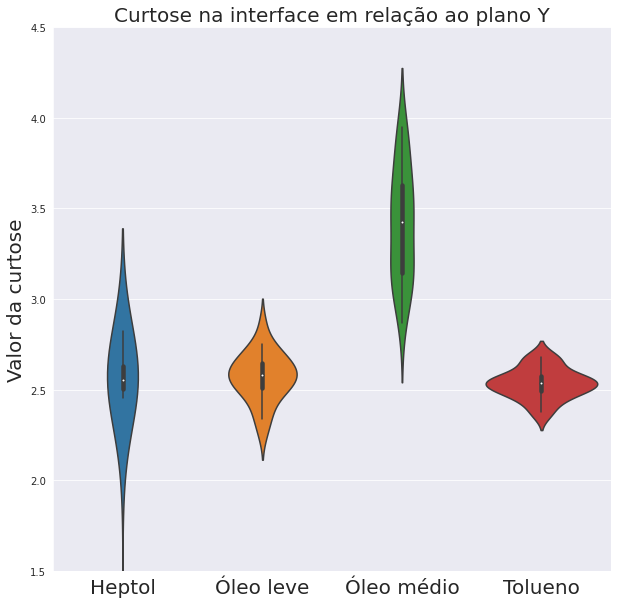

In [58]:
rcParams['figure.figsize'] = 10, 10
ax = sns.violinplot(x = " OIL", y = 'ARO.CUR.PLANE.Y.dat', data = df)

ax.set_ylim(bottom=1.5, top=4.5)
ax.set_title('Curtose na interface em relação ao plano Y', fontsize=20)
ax.set_xticklabels(['Heptol','Óleo leve','Óleo médio', 'Tolueno'],fontsize=20)
ax.set_xlabel("")
ax.set_ylabel("Valor da curtose",fontsize=20)

Text(0, 0.5, 'Valor da curtose')

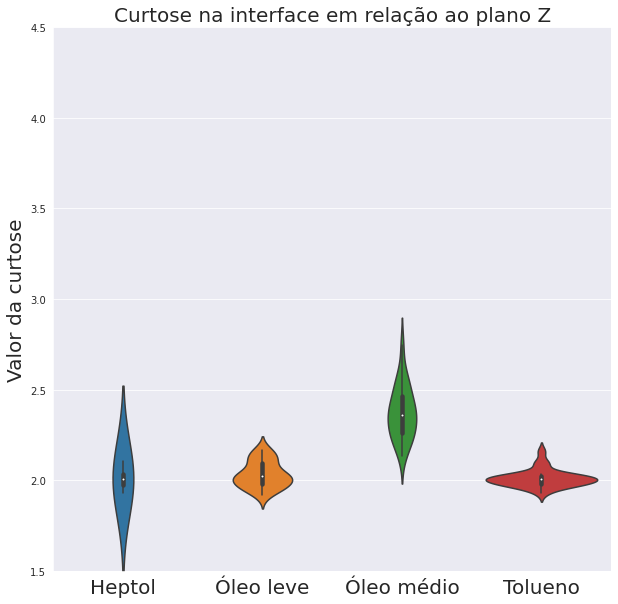

In [59]:
rcParams['figure.figsize'] = 10, 10

ax = sns.violinplot(x = " OIL", y = 'ARO.CUR.PLANE.Z.dat', data = df)
ax.set_ylim(bottom=1.5, top=4.5)
ax.set_title('Curtose na interface em relação ao plano Z', fontsize=20)
ax.set_xticklabels(['Heptol','Óleo leve','Óleo médio', 'Tolueno'],fontsize=20)
ax.set_xlabel("")
ax.set_ylabel("Valor da curtose",fontsize=20)

PLANO X

In [60]:
#for i in range(len(px)):
    #sns.relplot(x='IFT',y=px[i], data=df_px, hue=' OIL')
    #plt.savefig(str(px[i])+'.png')

Plano y

In [61]:
#for i in range(len(py)):
    #sns.relplot(x='IFT',y=py[i], data=df_py, hue=' OIL')
    #plt.savefig(str(py[i])+'.png')

Plano z

In [62]:
#for i in range(len(pz)):
    #sns.relplot(x='IFT',y=pz[i], data=df_pz, hue=' OIL')
    #plt.savefig(str(pz[i])+'.png')

VECT1

In [63]:
#for i in range(len(v1)):
    #sns.relplot(x='IFT',y=v1[i], data=df_v1, hue=' OIL')
    #plt.savefig(str(v1[i])+'.png')

VECT2

In [64]:
#for i in range(len(v2)):
    #sns.relplot(x='IFT',y=v2[i], data=df_v2, hue=' OIL')
    #plt.savefig(str(v2[i])+'.png')

# ENTROPIA

In [65]:
ent


['ENT.PLANE.X.123-TRIMETHYLBENZENE.DAT',
 'ENT.PLANE.X.124-TRIMETHYLBENZENE.DAT',
 'ENT.PLANE.X.135-TRIMETHYLBENZENE.DAT',
 'ENT.PLANE.X.ANTHRACENE.DAT',
 'ENT.PLANE.X.BENZENE.DAT',
 'ENT.PLANE.X.BENZOPYRENE.DAT',
 'ENT.PLANE.X.CYCLOHEPTANE.DAT',
 'ENT.PLANE.X.CYCLOHEXANE.DAT',
 'ENT.PLANE.X.CYCLOOCTANE.DAT',
 'ENT.PLANE.X.ISOBUTANE.DAT',
 'ENT.PLANE.X.ISOPENTANE.DAT',
 'ENT.PLANE.X.M-XYLENE.DAT',
 'ENT.PLANE.X.NAPHTHALENE.DAT',
 'ENT.PLANE.X.O-XYLENE.DAT',
 'ENT.PLANE.X.PHENANTHERENE.DAT',
 'ENT.PLANE.X.P-XYLENE.DAT',
 'ENT.PLANE.X.PYRENE.DAT',
 'ENT.PLANE.X.TOLUENE.DAT',
 'ENT.PLANE.Y.123-TRIMETHYLBENZENE.DAT',
 'ENT.PLANE.Y.124-TRIMETHYLBENZENE.DAT',
 'ENT.PLANE.Y.135-TRIMETHYLBENZENE.DAT',
 'ENT.PLANE.Y.ANTHRACENE.DAT',
 'ENT.PLANE.Y.BENZENE.DAT',
 'ENT.PLANE.Y.BENZOPYRENE.DAT',
 'ENT.PLANE.Y.CYCLOHEPTANE.DAT',
 'ENT.PLANE.Y.CYCLOHEXANE.DAT',
 'ENT.PLANE.Y.CYCLOOCTANE.DAT',
 'ENT.PLANE.Y.ISOBUTANE.DAT',
 'ENT.PLANE.Y.ISOPENTANE.DAT',
 'ENT.PLANE.Y.M-XYLENE.DAT',
 'ENT.PLANE.Y.NAPHT

Text(0, 0.5, 'Valor da curtose')

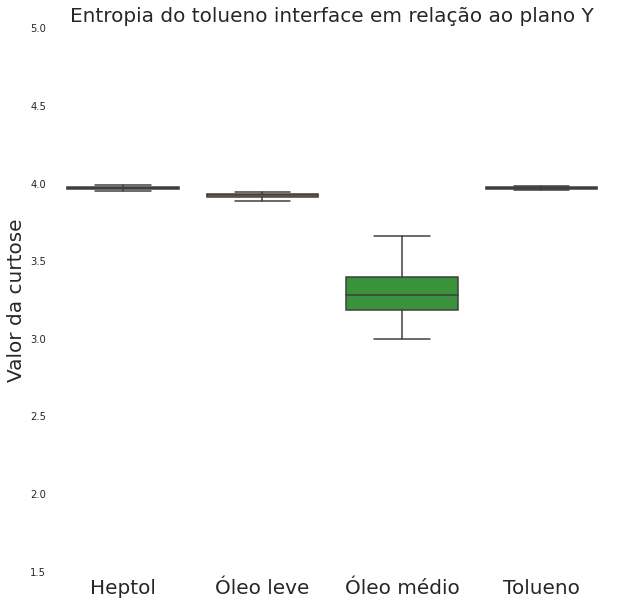

In [66]:
rcParams['figure.figsize'] = 10, 10

ax = sns.boxplot(x = " OIL", y = 'ENT.VECT1.Y.TOLUENE.DAT', data = df)
ax.set_ylim(bottom=1.5, top=5)
ax.set_title('Entropia do tolueno interface em relação ao plano Y', fontsize=20)
ax.set_xticklabels(['Heptol','Óleo leve','Óleo médio', 'Tolueno'],fontsize=20)
ax.set_facecolor("white")
ax.set_xlabel("")
ax.set_ylabel("Valor da curtose",fontsize=20)

Text(0, 0.5, 'Valor da curtose')

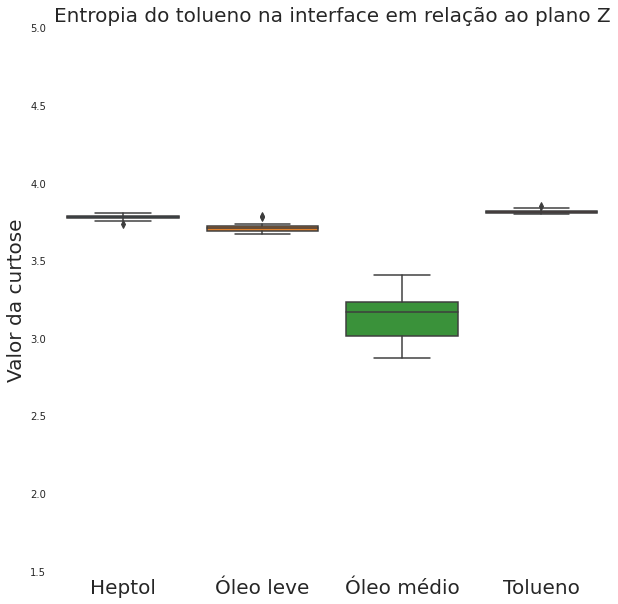

In [67]:
rcParams['figure.figsize'] = 10, 10

ax = sns.boxplot(x = " OIL", y = 'ENT.VECT1.Z.TOLUENE.DAT', data = df)
ax.set_ylim(bottom=1.5, top=5)
ax.set_facecolor("white")
ax.set_title('Entropia do tolueno na interface em relação ao plano Z', fontsize=20)
ax.set_xticklabels(['Heptol','Óleo leve','Óleo médio', 'Tolueno'],fontsize=20)
ax.set_xlabel("")
ax.set_ylabel("Valor da curtose",fontsize=20)